In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import postprocess as pp
import plots

postproc


# Investigating the fundamental traction


We study fundamental problem of a one-dimensional variational evolution,
which features non-trivial stability properties
such as:
    -
    -
    -

The problem is as follows:

Find $y_t$ such that:

GS)
$$
E(y_t)\leq E(z), \quad \forall z \in A(y_t)
$$

LS) 
$\exists \bar h: $
$$
E(y_t)\leq E(y_t + z), \quad \forall z \in .., ||z||\leq h
$$


In [45]:
# experiment = '../../test/output/one-dimensional-bar/10/afbc2c572471f96b35745efa388bed3d'
experiment = '../../test/output/one-dimensional-bar/5/24095fd74803e9b026dc82dba4f7e4c9'
params, data, signature = pp.load_data(experiment)


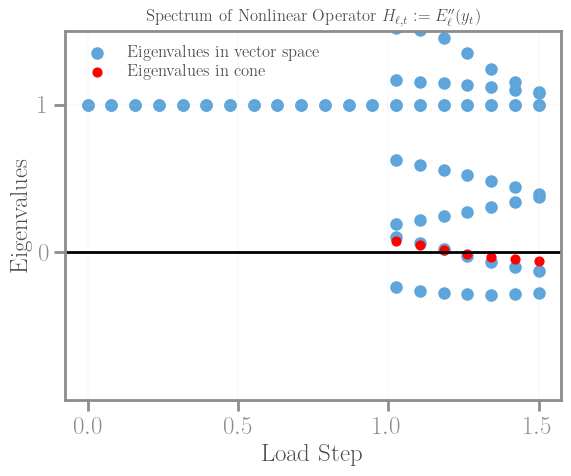

In [100]:
def plot_operator_spectrum(data):
    figure, axis = plt.subplots(1, 1)
    scale = data['eigs'].values[0][0]
    
    # Concatenate data for all load steps
    load_steps_all = np.concatenate([np.full_like(eigenvalues, load_step) for load_step, eigenvalues in zip(data['load'], data['eigs'])])
    eigenvalues_all = np.concatenate(data['eigs'])

    # Create a scatter plot with vertical alignment
    axis.scatter(load_steps_all, eigenvalues_all / scale, marker='o', label='Eigenvalues in vector space')
    axis.scatter(data.load, data['cone-eig'], c='r', s=40, label='Eigenvalues in cone')

    axis.set_xlabel('Load Step')
    axis.set_ylabel('Eigenvalues')
    axis.set_title('Spectrum of Nonlinear Operator $H_{\\ell, t}:=E_\\ell\'\'(y_t)$')
    axis.set_yticks([0, 1, -3])
    axis.axhline(0., c='k')
    axis.set_ylim(-1, 1.5)
    axis.grid(True)
    axis.legend()
    
    return figure, axis
    # axis.show()

plot_operator_spectrum(data)

## Analytical treatment